In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from pandas import read_csv
from sklearn.model_selection import train_test_split

import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def prepare_data(df, num_elements=50):
    new_data = []
    length = df.shape[0]
    current_index = 0
    step = int(0.2 * num_elements)
    while(current_index <= length - num_elements):
        new_data.append(df[current_index:current_index+num_elements])
        current_index += step
    return new_data

In [4]:
class BPNN(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(BPNN, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(input_size, hidden_size1)  
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def prepare_data(df, num_elements=50):
    new_data = []
    length = df.shape[0]
    current_index = 0
    step = int(0.2 * num_elements)
    while(current_index <= length - num_elements):
        new_data.append(df[current_index:current_index+num_elements])
        current_index += step
    return new_data

In [21]:
def learn(num, count, data_len, lr=0.01):
    num = [str(i) for i in range(num)]
    p1 = [read_csv('ics_data_preprocessed/06_Smart_Meter_45/P1/' + str(count) + '/' + n + '.csv', squeeze=True, parse_dates=['ts'], index_col='ts') for n in num]
    
    p1 = [prepare_data(df, data_len) for df in p1]
    p1 = sum(p1, [])
    p1 = [df.values.tolist() for df in p1]
    
    train, test = train_test_split(p1, test_size=0.2, random_state=42)
    train_data_normalized = train
    test_data_normalized = test
    
    train_data, val_data = train_test_split(train_data_normalized, test_size=0.15, random_state=42)
    train_data = torch.FloatTensor(train_data)
    val_data = torch.FloatTensor(val_data)
    test_data = torch.FloatTensor(test_data_normalized)
    
    X_train = train_data[:, :-10]
    y_train = train_data[:, -10:]
    X_val = val_data[:, :-10]
    y_val = val_data[:, -10:]
    X_test = test_data[:, :-10]
    y_test = test_data[:, -10:]
    
    print("Data is ready")
    
    best_model = BPNN(40, 50, 50)
    loss_function = nn.MSELoss()
    
    val_losses = []
    
    best_hidden_layer_size1 = 50
    best_hidden_layer_size2 = 50
    
    for hidden_layer_size1, hidden_layer_size2 in list(itertools.product([100, 150, 200, 250], [100, 150, 200, 250])):
        losses = []
        
    
        model = BPNN(data_len - 10, hidden_layer_size1, hidden_layer_size2)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
        epochs = 1000
        
        for i in range(epochs):
            model.train()
            
            optimizer.zero_grad()
            
            y_pred = model(X_train)
            single_loss = loss_function(y_pred, y_train)
            losses.append(single_loss)
            
            single_loss.backward()
            optimizer.step()
            
            
            model.eval()

            with torch.no_grad():
                y_pred = model(X_val)

                single_loss = loss_function(y_pred, y_val)

                if (len(val_losses) == 0) or (single_loss < min(val_losses)):
#                     if (len(val_losses) > 0):
#                         print("losses:", single_loss, min(val_losses))
                    best_hidden_layer_size1 = hidden_layer_size1
                    best_hidden_layer_size2 = hidden_layer_size2
                    best_model = model
                
                val_losses.append(single_loss)
            
#             if (len(val_losses) > 0 and i%5 == 1):
#                 print(val_losses[-1], min(val_losses))

#         print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
        print(hidden_layer_size1, hidden_layer_size2, "finished")
    print("best model hidden size:", best_hidden_layer_size1, best_hidden_layer_size2)
    
    predictions = []
    best_model.eval()
    with torch.no_grad():
        predictions = [best_model(seq) for (seq, labels) in zip(X_test, y_test)]
    pred = [torch.cat((i, j)) for (i, j) in zip(X_test, predictions)]
    actual_predictions = np.array([np.array(i) for i in pred])
    mape = [np.mean(np.abs(actual_predictions[i] - test[i])/np.abs(test[i])) for i in range(len(test))]
    print(sum(mape) / len(mape))
    rmse = [np.mean((actual_predictions[i] - test[i])**2)**.5 for i in range(len(test))]
    print(sum(rmse) / len(rmse))
    
    return best_model
     

In [22]:
random.seed(42)

# 1s

In [23]:
new_model = learn(22, 1000, 50)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 200
0.05296919807513094
30.38308727017487


In [24]:
new_model = learn(22, 1000, 100)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 200
0.002743638456543631
1.6684193601998631


In [25]:
new_model = learn(22, 1000, 150)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 250
0.031839905380919936
22.04880323841781


In [26]:
new_model = learn(22, 1000, 200)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 200
0.0064716161394984565
3.864278526592093


In [27]:
new_model = learn(22, 1000, 250)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 100
0.21832047187931647
109.39604313257986


In [28]:
new_model = learn(22, 1000, 300)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 200
0.12363971270628142
98.25210209819714


In [29]:
new_model = learn(22, 1000, 350)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 100
0.06739850895285701
272.3649339995849


In [30]:
new_model = learn(22, 1000, 400)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 250
0.40495816945848007
257.2888880182434


In [31]:
new_model = learn(22, 1000, 450)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 150
0.017522586534189904
56.98019113867909


In [32]:
new_model = learn(22, 1000, 500)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 200
0.037446673749777434
46.894892550065805


In [33]:
new_model = learn(22, 1000, 550)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 250
0.6855204005841502
503.0401620704642


In [34]:
new_model = learn(22, 1000, 600)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 250
0.05420944155622814
57.37026005394523


In [35]:
new_model = learn(22, 1000, 650)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 250
0.4076967697224709
329.59484762077585


In [36]:
new_model = learn(22, 1000, 700)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 250
0.5034815462200272
416.69663762651516


# 1.5s

In [37]:
new_model = learn(141, 1500, 50)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 250
0.008323625358234332
28.337011631721275


In [38]:
new_model = learn(141, 1500, 100)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 250
0.0026962839295946862
12.83973827656991


In [39]:
new_model = learn(141, 1500, 150)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 250
0.00185497576038211
11.39934095809457


In [40]:
new_model = learn(141, 1500, 200)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 100
0.00461118019776477
36.74268142080505


In [41]:
new_model = learn(141, 1500, 250)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 100
0.002590100601022252
26.173589629891254


In [42]:
new_model = learn(141, 1500, 300)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 200
0.0021115455162375833
17.246924531366872


In [43]:
new_model = learn(141, 1500, 350)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 200
0.001621764619959633
15.90347427001323


In [44]:
new_model = learn(141, 1500, 400)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 100
0.006579891914084113
44.95644394134097


In [45]:
new_model = learn(141, 1500, 450)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 150
0.002390141473392675
27.657419928263472


In [46]:
new_model = learn(141, 1500, 500)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 150
0.0022281680632658223
25.91288280463865


In [47]:
new_model = learn(141, 1500, 550)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 200
0.0031083603330983706
32.8043296190707


In [48]:
new_model = learn(141, 1500, 600)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 250
0.008763539548836905
55.30153835262251


In [49]:
new_model = learn(141, 1500, 650)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 100
1.9181122234495842e-05
0.14882778818571807


In [50]:
new_model = learn(141, 1500, 700)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 250
0.054362225233888076
369.20772052900645


# 2s

In [51]:
new_model = learn(902, 2000, 50)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 150
0.019650597034491183
11.487088008719496


In [52]:
new_model = learn(902, 2000, 100)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 200
0.005507533192320682
6.8768738948239125


In [53]:
new_model = learn(902, 2000, 150)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 150
0.012289020007491207
6.598205133858915


In [54]:
new_model = learn(902, 2000, 200)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 150
0.003967890143339241
5.327237017426535


In [55]:
new_model = learn(902, 2000, 250)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 100
0.005055001667722801
7.087419789500073


In [56]:
new_model = learn(902, 2000, 300)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 100
0.003647378245443943
6.316310578586483


In [57]:
new_model = learn(902, 2000, 350)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 200
0.0052925880203397125
5.485214377179752


In [58]:
new_model = learn(902, 2000, 400)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 100
0.002407877446329665
7.1547413476971915


In [59]:
new_model = learn(902, 2000, 450)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 100
0.004041027989304011
4.94582155138056


In [60]:
new_model = learn(902, 2000, 500)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 150
0.002323799164742428
6.653052422490992


In [61]:
new_model = learn(902, 2000, 550)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 250
0.0025585554253119004
7.21429065362872


In [62]:
new_model = learn(902, 2000, 600)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 200
0.03126884545777203
11.258273005309235


In [63]:
new_model = learn(902, 2000, 650)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 200
0.003013702237589755
4.691518364992067


In [64]:
new_model = learn(902, 2000, 700)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 250
0.0022247749385255694
4.865680763888445


In [65]:
new_model = learn(902, 2000, 750)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 100
0.00510172793951807
14.614628964292695


In [66]:
new_model = learn(902, 2000, 800)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 100
0.002960160413279207
6.637610439783449


In [67]:
new_model = learn(902, 2000, 850)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 250
0.0018365261024201232
5.41354638176929


In [68]:
new_model = learn(902, 2000, 900)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 100
0.002367120568759537
4.653330390266088


In [69]:
new_model = learn(902, 2000, 950)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 200
0.002250421065558176
5.457573680345012


In [70]:
new_model = learn(902, 2000, 1000)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 150
0.001190816533837356
3.022280058899337


# 5s

In [71]:
new_model = learn(19, 5000, 50)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 100
0.01841139679162557
47.78927462958406


In [72]:
new_model = learn(19, 5000, 100)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 250
0.01042467467019267
41.659404672936


In [73]:
new_model = learn(19, 5000, 150)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 200
0.00647980834177749
25.99773625911303


In [74]:
new_model = learn(19, 5000, 200)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 250
0.007405093001949514
29.920487867797142


In [75]:
new_model = learn(19, 5000, 250)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 100
0.004526844509743133
28.796818515504953


In [76]:
new_model = learn(19, 5000, 300)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 150
0.003683137375947953
25.93837927587366


In [77]:
new_model = learn(19, 5000, 350)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 100
0.0044118506966727014
25.972251487788174


In [78]:
new_model = learn(19, 5000, 400)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 100
0.004994219497903803
24.608274720577768


In [79]:
new_model = learn(19, 5000, 450)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 150
0.004079669355442523
22.246789986346123


In [80]:
new_model = learn(19, 5000, 500)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 150
0.0030624353797975654
19.878778569846798


In [81]:
new_model = learn(19, 5000, 550)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 250
0.0030736308756846935
33.49703600297445


In [82]:
new_model = learn(19, 5000, 600)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 150
0.00732111633426152
24.36941261649781


In [83]:
new_model = learn(19, 5000, 650)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 150
0.0030274055985378156
16.733782962204337


In [84]:
new_model = learn(19, 5000, 700)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 200
0.0031543730877334323
17.72914519652668


In [85]:
new_model = learn(19, 5000, 750)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 150
0.004731920289087053
28.59984009841312


In [86]:
new_model = learn(19, 5000, 800)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 150
0.003197792915102947
34.19612375045024


In [87]:
new_model = learn(19, 5000, 850)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 250
0.009016700350779682
39.816933106415334


In [88]:
new_model = learn(19, 5000, 900)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 250
0.0018175368847945846
18.85914690099456


In [89]:
new_model = learn(19, 5000, 950)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 150
0.001676188900553011
24.542078157955956


In [90]:
new_model = learn(19, 5000, 1000)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 100
0.0026960382961240753
27.287717645861807


# 15s

In [91]:
new_model = learn(20, 15000, 50)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 250
0.024783634460017478
51.42886434169563


In [92]:
new_model = learn(20, 15000, 100)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 200
0.025674257167052253
73.76885363280992


In [93]:
new_model = learn(20, 15000, 150)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 150
0.01102560685649487
36.83105192196364


In [94]:
new_model = learn(20, 15000, 200)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 100
0.020965767825265578
63.99596843013123


In [95]:
new_model = learn(20, 15000, 250)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 250
0.007722390573156121
27.32281878561326


In [96]:
new_model = learn(20, 15000, 300)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 100
0.00974728716904893
36.83381757281324


In [97]:
new_model = learn(20, 15000, 350)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 250
0.008867593461191207
38.143540310454085


In [98]:
new_model = learn(20, 15000, 400)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 250
0.008851399524438778
37.58970058411385


In [99]:
new_model = learn(20, 15000, 450)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 200
0.03028610006940123
45.68447859102702


In [100]:
new_model = learn(20, 15000, 500)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 150
0.0063637529279251545
32.00896093116064


In [101]:
new_model = learn(20, 15000, 550)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 150
0.01459843429043458
61.12760211514426


In [102]:
new_model = learn(20, 15000, 600)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 250
0.00334217338710008
13.471177510875469


In [103]:
new_model = learn(20, 15000, 650)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 150
0.005211501375578572
28.901048939872943


In [104]:
new_model = learn(20, 15000, 700)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 250
0.005923535120445148
23.83160719995512


In [105]:
new_model = learn(20, 15000, 750)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 150 200
0.005300778551387895
37.949023137571274


In [106]:
new_model = learn(20, 15000, 800)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 200 200
0.0017215198088561918
10.044896556192807


In [107]:
new_model = learn(20, 15000, 850)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 250 200
0.0016061563959499222
7.181552809708076


In [108]:
new_model = learn(20, 15000, 900)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 100
0.004262193572622844
12.038629074218116


In [109]:
new_model = learn(20, 15000, 950)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 100
0.0033821017856435266
32.8575136800854


In [110]:
new_model = learn(20, 15000, 1000)

Data is ready
100 100 finished
100 150 finished
100 200 finished
100 250 finished
150 100 finished
150 150 finished
150 200 finished
150 250 finished
200 100 finished
200 150 finished
200 200 finished
200 250 finished
250 100 finished
250 150 finished
250 200 finished
250 250 finished
best model hidden size: 100 200
0.0008471303734861541
8.970592927762263


In [8]:
num = [str(i) for i in range(902)]
p1 = [read_csv('ics_data_preprocessed/06_Smart_Meter_45/P1/2000/' + n + '.csv', squeeze=True, parse_dates=['ts'], index_col='ts') for n in num]
    
p1 = [prepare_data(df, 1000) for df in p1]
p1 = sum(p1, [])
p1 = [df.values.tolist() for df in p1]
    
train, test = train_test_split(p1, test_size=0.2, random_state=42)
train_data_normalized = train
test_data_normalized = test
    
train_data, val_data = train_test_split(train_data_normalized, test_size=0.15, random_state=42)
train_data = torch.FloatTensor(train_data)
val_data = torch.FloatTensor(val_data)
test_data = torch.FloatTensor(test_data_normalized)
    
X_train = train_data[:, :-10]
y_train = train_data[:, -10:]
X_val = val_data[:, :-10]
y_val = val_data[:, -10:]
X_test = test_data[:, :-10]
y_test = test_data[:, -10:]
    
print("Data is ready")
    
loss_function = nn.MSELoss()
    
val_losses = []
    
best_hidden_layer_size = 50
    

losses = []
        
    
best_model = BPNN(1000 - 10, 100, 150)
model = BPNN(1000 - 10, 100, 150)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
    
epochs = 1000
    
for i in range(epochs):
    model.train()
            
    optimizer.zero_grad()
            
    y_pred = model(X_train)
    single_loss = loss_function(y_pred, y_train)
    losses.append(single_loss)
            
    single_loss.backward()
    optimizer.step()
            
            
    model.eval()

    with torch.no_grad():
        y_pred = model(X_val)

        single_loss = loss_function(y_pred, y_val)

        if (len(val_losses) == 0) or (single_loss < min(val_losses)):

            best_model = model
                
        val_losses.append(single_loss)

    
print("best model hidden size:", best_hidden_layer_size)
    
predictions = []
best_model.eval()
with torch.no_grad():
    predictions = [best_model(seq) for (seq, labels) in zip(X_test, y_test)]
pred = [torch.cat((i, j)) for (i, j) in zip(X_test, predictions)]
actual_predictions = np.array([np.array(i) for i in pred])
mape = [np.mean(np.abs(actual_predictions[i] - test[i])/np.abs(test[i])) for i in range(len(test))]
print(sum(mape) / len(mape))
rmse = [np.mean((actual_predictions[i] - test[i])**2)**.5 for i in range(len(test))]
print(sum(rmse) / len(rmse))

Data is ready
best model hidden size: 50
0.011474165244653717
9.069465476925727


In [ ]:
# 2, 1000
# 100, 150
# new_model = learn(902, 2000, 1000)

In [10]:
predictions = []
best_model.eval()
with torch.no_grad():
    predictions = [best_model(seq) for (seq, labels) in zip(X_test, y_test)]
pred = [torch.cat((i, j)) for (i, j) in zip(X_test, predictions)]
actual_predictions = np.array([np.array(i) for i in pred])
mape = [np.mean(np.abs(actual_predictions[i] - test[i])/np.abs(test[i])) for i in range(len(test))]
print(sum(mape) / len(mape))
rmse = [np.mean((actual_predictions[i] - test[i])**2)**.5 for i in range(len(test))]
print(sum(rmse) / len(rmse))

0.011474165244653717
9.069465476925727


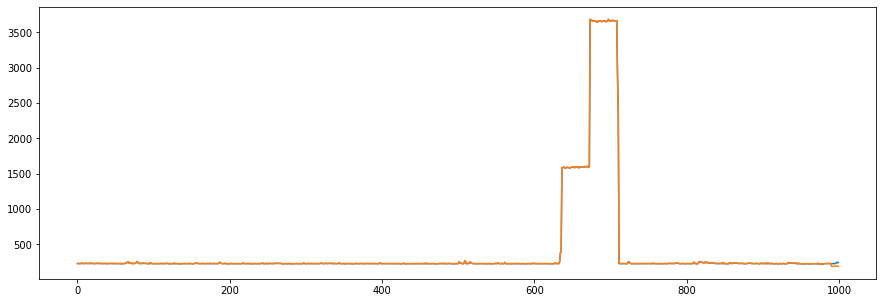

In [13]:
n = 2
plt.plot(test_data[n].numpy())
plt.plot(actual_predictions[n])

In [15]:
num = [str(i) for i in range(20)]
p1 = [read_csv('ics_data_preprocessed/06_Smart_Meter_45/P1/15000/' + n + '.csv', squeeze=True, parse_dates=['ts'], index_col='ts') for n in num]
    
p1 = [prepare_data(df, 200) for df in p1]
p1 = sum(p1, [])
p1 = [df.values.tolist() for df in p1]
    
train, test = train_test_split(p1, test_size=0.2, random_state=42)
train_data_normalized = train
test_data_normalized = test
    
train_data, val_data = train_test_split(train_data_normalized, test_size=0.15, random_state=42)
train_data = torch.FloatTensor(train_data)
val_data = torch.FloatTensor(val_data)
test_data = torch.FloatTensor(test_data_normalized)
    
X_train = train_data[:, :-10]
y_train = train_data[:, -10:]
X_val = val_data[:, :-10]
y_val = val_data[:, -10:]
X_test = test_data[:, :-10]
y_test = test_data[:, -10:]
    
print("Data is ready")
    
loss_function = nn.MSELoss()
    
val_losses = []
    
best_hidden_layer_size = 50
    

losses = []
        
    
best_model = BPNN(200 - 10, 100, 150)
model = BPNN(200 - 10, 100, 150)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
    
epochs = 1000
    
for i in range(epochs):
    model.train()
            
    optimizer.zero_grad()
            
    y_pred = model(X_train)
    single_loss = loss_function(y_pred, y_train)
    losses.append(single_loss)
            
    single_loss.backward()
    optimizer.step()
            
            
    model.eval()

    with torch.no_grad():
        y_pred = model(X_val)

        single_loss = loss_function(y_pred, y_val)

        if (len(val_losses) == 0) or (single_loss < min(val_losses)):

            best_model = model
                
        val_losses.append(single_loss)

    
print("best model hidden size:", best_hidden_layer_size)
    
predictions = []
best_model.eval()
with torch.no_grad():
    predictions = [best_model(seq) for (seq, labels) in zip(X_test, y_test)]
pred = [torch.cat((i, j)) for (i, j) in zip(X_test, predictions)]
actual_predictions = np.array([np.array(i) for i in pred])
mape = [np.mean(np.abs(actual_predictions[i] - test[i])/np.abs(test[i])) for i in range(len(test))]
print(sum(mape) / len(mape))
rmse = [np.mean((actual_predictions[i] - test[i])**2)**.5 for i in range(len(test))]
print(sum(rmse) / len(rmse))

Data is ready
best model hidden size: 50
0.04809797486251463
84.64318224796742


In [ ]:
# new_model = learn(20, 15000, 200)
# 100, 100

In [16]:
predictions = []
best_model.eval()
with torch.no_grad():
    predictions = [best_model(seq) for (seq, labels) in zip(X_test, y_test)]
pred = [torch.cat((i, j)) for (i, j) in zip(X_test, predictions)]
actual_predictions = np.array([np.array(i) for i in pred])
mape = [np.mean(np.abs(actual_predictions[i] - test[i])/np.abs(test[i])) for i in range(len(test))]
print(sum(mape) / len(mape))
rmse = [np.mean((actual_predictions[i] - test[i])**2)**.5 for i in range(len(test))]
print(sum(rmse) / len(rmse))

0.04809797486251463
84.64318224796742


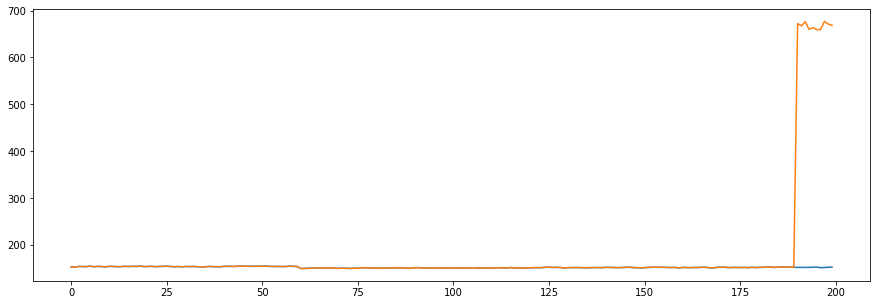

In [20]:
n = 1
plt.plot(test_data[n].numpy())
plt.plot(actual_predictions[n])